In [ ]:
dataset_identifier = "victordibia/signverod"

# Mount your Google Drive.
from google.colab import drive
drive.mount("/content/drive")

kaggle_creds_path = "/content/drive/MyDrive/kaggle.json"

! pip install kaggle --quiet

! mkdir -p ~/.kaggle
! cp {kaggle_creds_path} ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download {dataset_identifier}

! mkdir -p kaggle_data
! unzip {dataset_identifier.split('/')[-1] + ".zip"} -d kaggle_data

# Unmount your Google Drive
drive.flush_and_unmount()




In [ ]:
dataset_identifier = "shreelakshmigp/cedardataset"

# Mount your Google Drive.
from google.colab import drive
drive.mount("/content/drive")

kaggle_creds_path = "/content/drive/MyDrive/kaggle.json"

! pip install kaggle --quiet

! mkdir -p ~/.kaggle
! cp {kaggle_creds_path} ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download {dataset_identifier}

! mkdir -p kaggle_data
! unzip {dataset_identifier.split('/')[-1] + ".zip"} -d kaggle_data

# Unmount your Google Drive
drive.flush_and_unmount()

In [ ]:
import pandas as pd
import numpy as np
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf



In [ ]:
train = pd.read_csv("kaggle_data/train.csv")
train.head()

,area,bbox,category_id,id,image_id
0,0.009,"[0.14669516046674358, 0.8172596266496202, 0.33...",1,4,2
1,0.010,"[0.1830540707236842, 0.8483832465277777, 0.293...",1,5,2
2,0.008,"[0.21358420632102273, 0.8757179542824074, 0.23...",1,6,2
3,0.006,"[0.5366111738148984, 0.899244842346794, 0.0856...",2,7,3
4,0.005,"[0.6299114700902935, 0.90049396494709, 0.06553...",2,8,3


In [ ]:
test = pd.read_csv("kaggle_data/test.csv")
test.shape[0]

1666

In [ ]:
categories = pd.read_csv("kaggle_data/categories.csv")
categories.head()

,id,name
0,1,signature
1,2,initials
2,3,redaction
3,4,date


In [ ]:
img_ids = pd.read_csv("kaggle_data/image_ids.csv")
img_ids.head()

,height,width,id,file_name
0,3300.0,2560.0,1,nist_r0392_01.png
1,3300.0,2560.0,2,nist_r0647_01.png
2,4454.0,3480.0,3,gsa_LAL50113-Lease-_Z-03.png
3,3300.0,2560.0,4,nist_r0169_01.png
4,4411.0,3422.0,5,gsa_(R)LDC02012-Lease-SF2-04.png


In [ ]:
img_ids.rename(columns={"id":"image_id"}, inplace=True)

train_df = pd.merge(img_ids, train, on=["image_id"])
train_df = train_df[train_df.get("category_id") == 1]
train_df.head()

,height,width,image_id,file_name,area,bbox,category_id,id
0,3300.0,2560.0,2,nist_r0647_01.png,0.009,"[0.14669516046674358, 0.8172596266496202, 0.33...",1,4
1,3300.0,2560.0,2,nist_r0647_01.png,0.010,"[0.1830540707236842, 0.8483832465277777, 0.293...",1,5
2,3300.0,2560.0,2,nist_r0647_01.png,0.008,"[0.21358420632102273, 0.8757179542824074, 0.23...",1,6
22,4400.0,3400.0,2,gsa_LAZ02625-Lease-1_Z-05.png,0.009,"[0.14669516046674358, 0.8172596266496202, 0.33...",1,4
23,4400.0,3400.0,2,gsa_LAZ02625-Lease-1_Z-05.png,0.010,"[0.1830540707236842, 0.8483832465277777, 0.293...",1,5


In [ ]:
test_df = pd.merge(test, img_ids, on=["image_id"])
test_df = test_df[test_df.get("category_id") == 1]

In [ ]:
image_paths = glob.glob('kaggle_data/signatures/*/*.png')
image_paths[0]

'kaggle_data/signatures/full_forg/forgeries_17_3.png'

In [ ]:
def clean_image2(img_path, coord=None):
    img = cv2.imread(img_path)
    if coord:
        coord = ast.literal_eval(coord)
        x, y, x2, y2 = [float(i) for i in coord]
        x = int(round(x * img.shape[1]))
        x2 = int(round(x2 * img.shape[1]))
        y = int(round(y * img.shape[0]))
        y2 = int(round(y2 * img.shape[0]))
        img = img[y: y + y2, x: x + x2]
    img = resize_img(img)

    # Convert to grayscale and threshold
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, binary_image = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Convert binary_image to 3-channel
    binary_3channel = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2BGR)

    tensor_img = tf.convert_to_tensor(binary_3channel, dtype=tf.float32)

    return tensor_img / 255.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
fonts_directory = "/content/drive/MyDrive/fonts_folder"

Mounted at /content/drive


In [ ]:
import ast
from torchvision import transforms
from PIL import Image

# reszie the img to the small size for autoencoder
# to save rams, since only have 23.7 GB
def resize_img(img, tar_size=(224, 224)):
  # Convert OpenCV BGR image to RGB PIL Image
  pil_img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

  # Apply the resize transform
  resize_transform = transforms.Resize(tar_size)
  resized_img = resize_transform(pil_img)

  # Convert back to BGR OpenCV image
  return cv2.cvtColor(np.array(resized_img), cv2.COLOR_RGB2BGR)


# gray scale, binary_img, and crop coorindates
def clean_image(img_path, coord=None):
  img = cv2.imread(img_path)
  if coord:
    coord = ast.literal_eval(coord)
    x, y, x2, y2 = [float(i) for i in coord]
    x = int(round(x * img.shape[1]))
    x2 = int(round(x2 * img.shape[1]))
    y = int(round(y * img.shape[0]))
    y2 = int(round(y2 * img.shape[0]))
    img = img[y: y + y2, x: x + x2]
  img = resize_img(img)
  gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  ret, binary_image = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  tensor_img = tf.convert_to_tensor(binary_image, dtype=tf.float32)
  return tf.reshape(tensor_img, (224, 224, 1)) / 255.0


In [ ]:
import random
from random import choice, randint
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet
from PIL import Image, ImageDraw, ImageFont


def add_slant(image, max_angle=5):
    angle = np.random.uniform(-max_angle, max_angle)
    M = cv2.getRotationMatrix2D((image.shape[1] / 2, image.shape[0] / 2), angle, 1)
    return cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))

def add_lines(image, max_lines=5, max_width=5):
    output = image.copy()
    num_lines = randint(1, max_lines)
    for _ in range(num_lines):
        y = randint(0, image.shape[0]-1)
        width = randint(1, max_width)
        output[y:y+width, :] = 0  # black lines
    return output


primary_words = ["Board of Trustees", "Trustee", "Meeting", "Board", "Best Wishes", "Wishes", "Best",
                 "Yours Truly", "Yours", "Sincerely", "President", "Chairman", "Phd"]

# List all .ttf files in the directory
font_files = [f for f in os.listdir(fonts_directory) if f.endswith('.ttf')]

# Construct the font_paths dictionary
font_paths = {os.path.splitext(font_file)[0]: os.path.join(fonts_directory, font_file) for font_file in font_files}

def get_word():
    words = list(set(wordnet.words()))
    word = choice(words)

    if random.random() > 0.7:
        word = word + " " + choice(primary_words)

    prob = random.random()
    if prob < 0.25:
        return word.lower()
    elif prob > 0.25 and prob <  0.75:
        return word.upper()
    elif prob > 0.75:
        return word.capitalize()
    return word

def get_text():
    common_words = ["yours", "sincerely"]
    punctuations = [",", ".", "!", "?"]
    selected_words = [get_word() for _ in range(randint(1, 5))] + common_words
    return " ".join(selected_words) + choice(punctuations)

def add_text(clean_image_path):
    # Convert numpy image to PIL Image
    noisy_image = Image.fromarray(clean_image_path)
    draw = ImageDraw.Draw(noisy_image)


    # Get a random font and set size
    font_name = choice(list(font_paths.keys()))
    font_size = randint(12, 14)
    font = ImageFont.truetype(font_paths[font_name], font_size)

    text = get_text()
    y = randint(20, noisy_image.size[1] - 20)
    draw.text((10, y), text, font=font, fill="black")

    # TODO: Skewing logic if you want to keep it. This will require some manipulation using PIL.

    return np.array(noisy_image)






def add_noise(img):

    # Convert tensor to numpy for further processing
    np_img = (img.numpy() * 255).astype(np.uint8)

    # Add other augmentations
    np_img = add_slant(np_img)
    np_img = add_lines(np_img)
    np_img = add_text(np_img)

    # Convert the modified numpy image back to TensorFlow tensor and normalize to [0, 1]
    noise_img = tf.expand_dims(tf.convert_to_tensor(np_img, dtype=tf.float32) / 255.0, axis=-1)

    return noise_img

[nltk_data] Downloading package wordnet to /root/nltk_data...


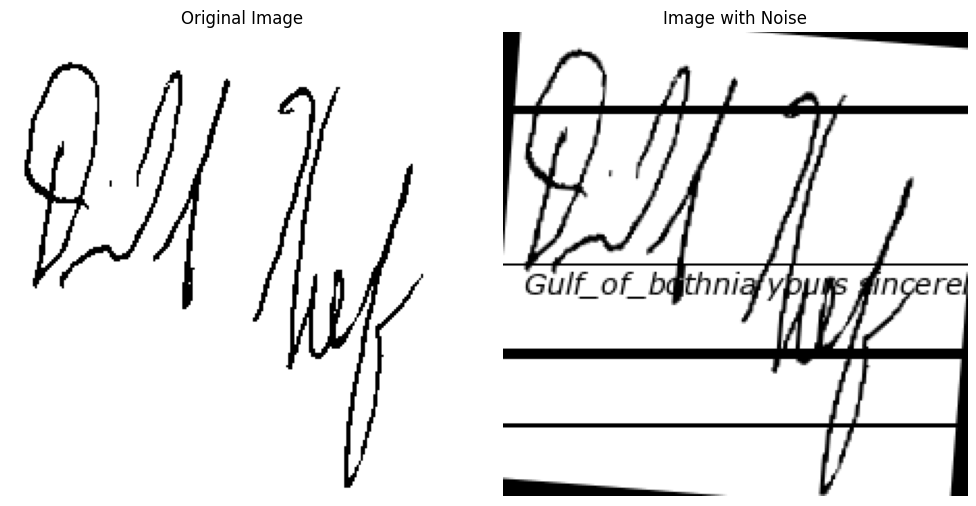

In [ ]:

image_paths = glob.glob('kaggle_data/signatures/*/*.png')
org_img = clean_image(os.path.join(image_paths[1]))
dirty_img = add_noise(org_img)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(org_img.numpy().squeeze(), cmap='gray')
ax[0].set_title("Original Image")
ax[0].axis('off')

ax[1].imshow(dirty_img.numpy().squeeze(), cmap='gray')
ax[1].set_title("Image with Noise")
ax[1].axis('off')

plt.tight_layout()
plt.show()


In [31]:
img_dir = "kaggle_data/images"
img_files = os.listdir(img_dir)


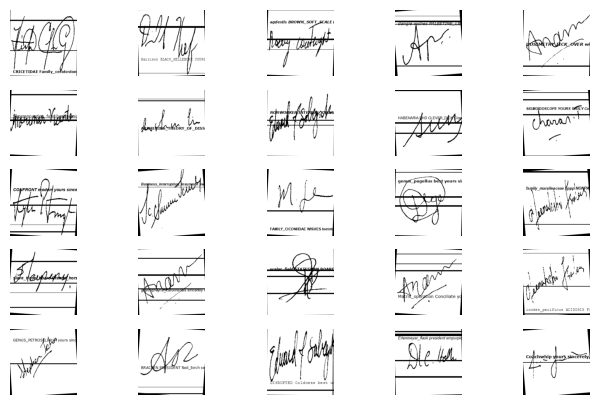

In [ ]:
fig, axes = plt.subplots(5, 5, figsize=(8, 5)) # 5 rows, 5 columns for 25 images

count = 0
for img_path in image_paths:
    if count >= 25: # Stop after 25 images
        break

    noise_img = add_noise(clean_image(os.path.join(img_path)))
    ax = axes[count // 5, count % 5] # Determine the row and column for the subplot
    ax.imshow(noise_img, cmap='gray') # Display the image
    ax.axis('off') # Turn off the axis
    count += 1

plt.show()



In [ ]:
# all functions to load datas into autoencoder

def load(img_path):
  # orders matter, input noise and target clean
  img_path = img_path.numpy().decode('utf-8')
  clean_img = clean_image(img_path)
  noise_img = add_noise(clean_img)
  return noise_img, clean_img

def tf_load(img_path):
  # Ensure the function returns two tf.float32 tensors
  return tf.py_function(load, [img_path], [tf.float32, tf.float32])


def process_data(image_paths):
    image_paths = image_paths * 5
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.shuffle(len(image_paths))  # suffule
    dataset = dataset.map(tf_load, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(32) # Or any other batch size
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

def SSIMLoss(y_true, y_pred):
    return 1.0 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

In [ ]:
# dataset use to train the autoencoder
# 80/20 split
num_images = len(image_paths)
size = int(num_images * 0.8)

train = image_paths[:size]
test = image_paths[size:]
train_dataset = process_data(train)
val_dataset = process_data(test)


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Conv2DTranspose, BatchNormalization, Activation, Add
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model



def autoencoder_model(input_shape=(224, 224, 1)):
    # Input
    input_img = Input(shape=input_shape)
    x = input_img
    num_filters = 64
    residual_connections = []

    # Encoder
    for i in range(3):
        x = Conv2D(num_filters, (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

        x = Conv2D(num_filters, (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

        # Store tensor for residual connection
        residual_connections.append(x)

        x = MaxPooling2D((2, 2), padding="same")(x)
        x = Dropout(0.1)(x)

        num_filters *= 2

    # Decoder
    for i in range(2, -1, -1):
        num_filters //= 2

        x = Conv2DTranspose(num_filters, (3, 3), strides=2, padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

        # Utilize residual connection
        x = Add()([x, residual_connections[i]])

    # Final layer
    x = Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

    model = Model(input_img, x)

    return model

# Optimizer
'''lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    0.0002,
    decay_steps=300,
    decay_rate=0.8,
    staircase=False
)'''

lr_schedule =tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9
)

opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


autoencoder = autoencoder_model()
autoencoder.compile(optimizer=opt, loss='binary_crossentropy',
                    metrics=[SSIMLoss])

autoencoder.summary()

autoencoder.fit(train_dataset, validation_data=val_dataset, epochs=8)


# Save the model
from google.colab import drive
drive.mount('/content/drive')

# Ensure the directory exists or create it
import os
if not os.path.exists("/content/drive/MyDrive/autoencoder"):
    os.makedirs("/content/drive/MyDrive/autoencoder")

# Save the model
model_path = "/content/drive/MyDrive/autoencoder/model_final.h5"
autoencoder.save(model_path)






Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 64)         640       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 224, 224, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 224, 224, 64)         0         ['batch_normalization[0][0

KeyboardInterrupt: ignored

1/1 [==============================] - 3s 3s/step


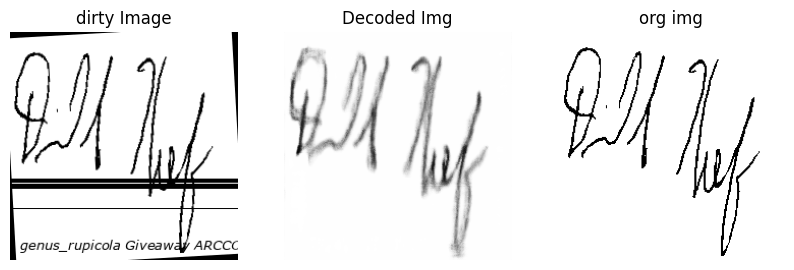

In [ ]:

org_img = clean_image(os.path.join(image_paths[1]))
dirty_img = add_noise(org_img)

# Add batch dimension to the example
input_image = tf.expand_dims(dirty_img, axis=0)

# predict the output
decoded_image = autoencoder.predict(input_image)

# Remove batch dimension
decoded_image = tf.squeeze(decoded_image)

# If the decoded image has a channel dimension with size 1, you can remove it
if decoded_image.shape[-1] == 1:
    decoded_image = decoded_image[..., 0]

# Scale the image data
decoded_image = (decoded_image * 255).numpy().astype('uint8')


# Display the original dirty and decoded images
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].imshow(dirty_img, cmap='gray')
axes[0].set_title('dirty Image')
axes[0].axis('off')
axes[1].imshow(decoded_image, cmap='gray')
axes[1].set_title('Decoded Img')
axes[1].axis('off')
axes[2].imshow(org_img, cmap='gray')
axes[2].set_title('org img')
axes[2].axis('off')

plt.show()


1/1 [==============================] - 0s 19ms/step


IndexError: ignored

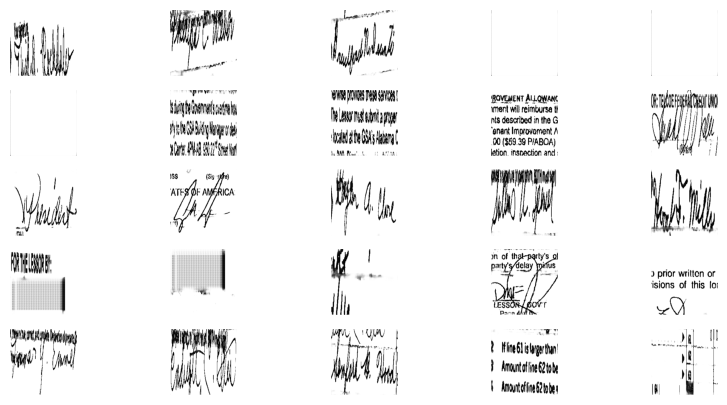

In [ ]:
img_dir = "kaggle_data/images"
img_files = os.listdir(img_dir)
fig, axes = plt.subplots(5, 5, figsize=(10, 5)) # 5 rows, 5 columns for 25 images

count = 0
for index, row in train_df.iterrows():
    noise_img = clean_image(os.path.join(img_dir, row["file_name"]), row["bbox"])
    noise_img = tf.expand_dims(noise_img, axis=0)
    # predict the output
    decoded_image = autoencoder.predict(noise_img)
    # Remove batch dimension
    decoded_image = tf.squeeze(decoded_image)

    ax = axes[count // 5, count % 5] # Determine the row and column for the subplot
    ax.imshow(decoded_image, cmap='gray') # Display the image
    ax.axis('off') # Turn off the axis
    count += 1

plt.show()

1/1 [==============================] - 0s 18ms/step


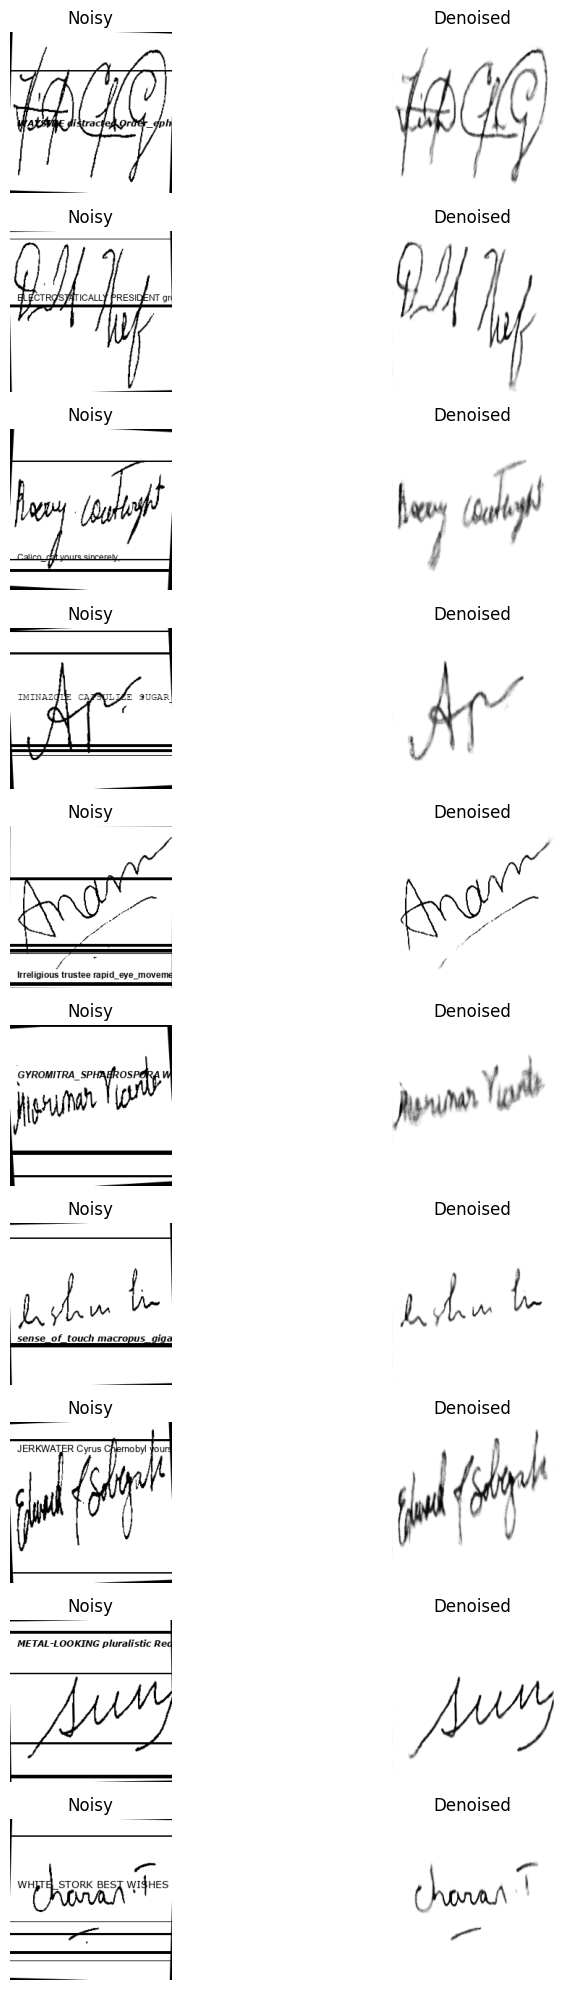

In [33]:
fig, axes = plt.subplots(10, 2, figsize=(10, 20)) # 10 rows, 2 columns for 10 pairs of images

count = 0
for img_path in image_paths:
    if count >= 10: # Stop after 10 images
        break

    clean_img = clean_image(os.path.join(img_path))
    noise_img = add_noise(clean_img)
    noise_img_batch = tf.expand_dims(noise_img, axis=0)

    # predict the output
    decoded_image = autoencoder.predict(noise_img_batch)
    # Remove batch dimension
    decoded_image = tf.squeeze(decoded_image).numpy()

    # Display noisy image
    ax = axes[count, 0]
    ax.imshow(noise_img, cmap='gray')
    ax.axis('off')
    ax.set_title('Noisy')

    # Display denoised image
    ax = axes[count, 1]
    ax.imshow(decoded_image, cmap='gray')
    ax.axis('off')
    ax.set_title('Denoised')

    count += 1

plt.tight_layout()
plt.show()



In [ ]:
import torch

conf_threshold = 0.5

# Load the model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Set up the plot for 5 images
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 5))

# We'll loop through the first 5 images from the dataframe
for index, (ax, (_, row)) in enumerate(zip(axes, train_df.iterrows())):
    if index >= 5:
        break

    image_path = os.path.join(img_dir, row["file_name"])
    processed_img = clean_image2(image_path, row["bbox"])  # Assuming clean_image2 is defined elsewhere
    processed_img_np = np.array(processed_img)  # Convert to numpy array for visualization
    if len(processed_img_np.shape) == 2:  # if the image is grayscale
        processed_img_np = np.stack([processed_img_np] * 3, axis=-1)

    processed_img = processed_img_np.transpose((2, 0, 1))
    processed_img = torch.from_numpy(processed_img).float().div(255.0).unsqueeze(0)

    results = model(processed_img)

    # Use YOLOv5's built-in rendering function
    results.render()
    image_with_detections = results.imgs[0]  # Image with bounding boxes
    ax.imshow(cv2.cvtColor(image_with_detections, cv2.COLOR_BGR2RGB))
    ax.axis('off')

plt.tight_layout()
plt.show()








In [ ]:
import torch
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image as keras_image

conf_threshold = 0.5

# Load the model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

for index, row in train_df.iterrows():
    if index < 13:
      continue
    if index >= 15:
        break

    image_path = os.path.join(img_dir, row["file_name"])
    processed_img = clean_image2(image_path, row["bbox"])  # Assuming clean_image2 is defined elsewhere

    # Save the processed image temporarily
    temp_image_path = 'temp_image.jpg'
    keras_image.save_img(temp_image_path, processed_img)

    # Run inference on the processed image
    results = model(temp_image_path)

    # Show the results
    results.show()





In [ ]:
img_dir = "kaggle_data/images"
img_files = os.listdir(img_dir)
fig, axes = plt.subplots(2, 5, figsize=(10, 5)) # 5 rows, 5 columns for 25 images

count = 0
for index, row in train_df.iterrows():
    if index < 150:
      continue
    if count >= 10: # Stop after 25 images
        break
    noise_img = clean_image(os.path.join(img_dir, row["file_name"]), row["bbox"])
    noise_img = tf.expand_dims(noise_img, axis=0)
    # predict the output
    decoded_image = model.predict(noise_img)
    # Remove batch dimension
    decoded_image = tf.squeeze(decoded_image)

    ax = axes[count // 5, count % 5] # Determine the row and column for the subplot
    ax.imshow(decoded_image, cmap='gray') # Display the image
    ax.axis('off') # Turn off the axis
    count += 1

plt.show()